# **Traffic Classification using Deep Learning**

### Import useful libraries

In [1]:
!pip install -q -U keras-tuner

In [2]:
import pickle
import numpy as np
import pandas as pd
import sklearn
import imblearn
from imblearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Model

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

### Link gdrive


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
path = "gdrive/MyDrive/Dataset_csv/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Get labels

In [ ]:
p_field = ["b" + str(i) for i in range(784)]
class_df = pd.read_parquet('gdrive/MyDrive/dataset_cnn_784.parquet', columns=['class'])
labels = np.array(class_df['class'])
labels = labels.astype("int32")
features_list = list(p_field)
classes = np.unique(labels)

### Train-test splitting

In [ ]:
from sklearn.model_selection import train_test_split

samples_train, samples_test, categorical_labels_train, categorical_labels_test = \
    train_test_split(pd.read_parquet('gdrive/MyDrive/dataset_cnn_784.parquet', columns= p_field),labels, shuffle=True, random_state=0,stratify=labels)


###Info saving


In [ ]:
samples_train.to_parquet("gdrive/MyDrive/temporary_file/samples_train.parquet")
samples_test.to_parquet("gdrive/MyDrive/temporary_file/samples_test.parquet")
np.savetxt("gdrive/MyDrive/temporary_file/categorical_labels_train.csv",categorical_labels_train)
np.savetxt("gdrive/MyDrive/temporary_file/categorical_labels_test.csv",categorical_labels_test)

### Get train from parquet 
  restart runtime and start from here

In [4]:
samples_train = pd.read_parquet("gdrive/MyDrive/temporary_file/samples_train.parquet")
categorical_labels_train = np.loadtxt("gdrive/MyDrive/temporary_file/categorical_labels_train.csv")
samples_train = np.expand_dims(samples_train, axis=2)

###Evaluate

In [5]:
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from imblearn.metrics import geometric_mean_score


def evaluate(xtest, ytest, ypred, title):

  accuracy_score(ytest, ypred) #Accuracy

  macro_gmean = np.mean(geometric_mean_score(ytest, ypred, average=None))
  print('macro g-mean -> ' + str(macro_gmean))

  print(classification_report(ypred, ytest)) #Detailed metrics

  mat = confusion_matrix(ytest, ypred, normalize='true') #Confusion matrix seaborn
  plt.figure(figsize=(12, 8), dpi=70)
  ax = plt.subplot()
  sns.heatmap(mat.T*100, square=True, annot=True, vmin=0.0, vmax=100.0, 
              cbar=True, ax=ax, xticklabels=classes, yticklabels=classes, 
              linewidths=1,fmt='1.4f', annot_kws={"size":14}) 
  sns.set(font_scale=1.2) 
  plt.xlabel('True Label')
  plt.ylabel('Predicted Label')
  plt.title(title)

### Define DL CNN-based architecture

In [7]:
def model_builder(hp):
  model = keras.Sequential()
  input_shape = samples_train.shape[1:]
  #num_classes = len(set(categorical_labels_test))
  num_classes = 13

  input_payload = Input(shape=input_shape, name='input_payload')

  model.add(Conv1D(filters=16, kernel_size=25, strides=1, kernel_constraint=MaxNorm(3), padding='same', activation='relu', name='Conv1'))
  
  model.add(MaxPooling1D(pool_size=3, strides=None, padding='same'))

  model.add(Conv1D(filters=32, kernel_size=25, strides=1, kernel_constraint=MaxNorm(3), padding='same', activation='relu', name='Conv2'))
  model.add(MaxPooling1D(pool_size=3, strides=None, padding='same'))

  model.add(Flatten())
  model.add(Dropout(0.2))

  model.add(Dense(256, activation='relu', kernel_constraint=MaxNorm(3)))
  model.add(Dropout(0.2))

  model.add(Dense(16, kernel_constraint=MaxNorm(3), activation='softmax', name='output_wang'))

  #model = Model(inputs=input_payload, outputs=output_payload, name='traffic_classification_1DCNN')

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model



### Hyper-parameter tuning

In [8]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3, #trial number
                     directory='my_dir',
                     project_name='intro_to_kt')

In [9]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(samples_train, categorical_labels_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 1 Complete [00h 05m 26s]
val_accuracy: 0.6354660391807556

Best val_accuracy So Far: 0.6354660391807556
Total elapsed time: 00h 05m 26s
INFO:tensorflow:Oracle triggered exit


In [11]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(samples_train, categorical_labels_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


16243/16243 [==============================] - 136s 8ms/step - loss: 1.0744 - accuracy: 0.6344 - val_loss: 1.0306 - val_accuracy: 0.6355
Epoch 2/50
16243/16243 [==============================] - 143s 9ms/step - loss: 1.0252 - accuracy: 0.6387 - val_loss: 1.0264 - val_accuracy: 0.6364
Epoch 3/50
16243/16243 [==============================] - 134s 8ms/step - loss: 1.0215 - accuracy: 0.6391 - val_loss: 1.0253 - val_accuracy: 0.6356
Epoch 4/50
16243/16243 [==============================] - 134s 8ms/step - loss: 1.0198 - accuracy: 0.6395 - val_loss: 1.0236 - val_accuracy: 0.6366
Epoch 5/50
16243/16243 [==============================] - 143s 9ms/step - loss: 1.0190 - accuracy: 0.6394 - val_loss: 1.0239 - val_accuracy: 0.6366
Epoch 6/50
16243/16243 [==============================] - 135s 8ms/step - loss: 1.0190 - accuracy: 0.6395 - val_loss: 1.0241 - val_accuracy: 0.6358
Epoch 7/50
16243/16243 [==============================] - 143s 9ms/step - loss: 1.0182 - accuracy: 0.6395 - val_loss: 1.024

In [12]:
hypermodel = tuner.hypermodel.build(best_hps)
# Retrain the model
hypermodel.fit(samples_train, categorical_labels_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/41


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


16243/16243 [==============================] - 136s 8ms/step - loss: 1.0761 - accuracy: 0.6342 - val_loss: 1.0323 - val_accuracy: 0.6345
Epoch 2/41
16243/16243 [==============================] - 133s 8ms/step - loss: 1.0258 - accuracy: 0.6382 - val_loss: 1.0258 - val_accuracy: 0.6356
Epoch 3/41
16243/16243 [==============================] - 140s 9ms/step - loss: 1.0216 - accuracy: 0.6391 - val_loss: 1.0246 - val_accuracy: 0.6364
Epoch 4/41
16243/16243 [==============================] - 132s 8ms/step - loss: 1.0201 - accuracy: 0.6397 - val_loss: 1.0240 - val_accuracy: 0.6366
Epoch 5/41
16243/16243 [==============================] - 133s 8ms/step - loss: 1.0194 - accuracy: 0.6395 - val_loss: 1.0256 - val_accuracy: 0.6365
Epoch 6/41
16243/16243 [==============================] - 133s 8ms/step - loss: 1.0189 - accuracy: 0.6396 - val_loss: 1.0239 - val_accuracy: 0.6358
Epoch 7/41
16243/16243 [==============================] - 132s 8ms/step - loss: 1.0182 - accuracy: 0.6398 - val_loss: 1.024

In [13]:
from keras.models import load_model
hypermodel.save('gdrive/MyDrive/models/hypermodel.h5')

###Get test from parquet
restart runtime and start from here

In [14]:
samples_test = pd.read_parquet("gdrive/MyDrive/temporary_file/samples_test.parquet")
categorical_labels_test = np.loadtxt("gdrive/MyDrive/temporary_file/categorical_labels_test.csv")
samples_test = np.expand_dims(samples_test, axis=2)

### Prediction

In [ ]:
from keras.models import load_model
hypermodel = load_model('gdrive/MyDrive/models/hypermodel.h5')

In [15]:
eval_result = hypermodel.evaluate(samples_test, categorical_labels_test)
print("[test loss, test accuracy]:", eval_result)

soft_values = hypermodel.predict(samples_test, verbose=2)
prediction_test = soft_values.argmax(axis=-1)

6768/6768 [==============================] - 27s 4ms/step - loss: 1.0169 - accuracy: 0.6393
[test loss, test accuracy]: [1.0168818235397339, 0.6392671465873718]
6768/6768 - 10s


### Evaluate CNN-based traffic classifier

In [16]:
soft_values = hypermodel.predict(samples_test, verbose=2)
prediction_test = soft_values.argmax(axis=-1)

accuracy = sklearn.metrics.accuracy_score(categorical_labels_test, prediction_test)
fmeasure = sklearn.metrics.f1_score(categorical_labels_test, prediction_test, average='macro')
macro_gmean = np.mean(imblearn.metrics.geometric_mean_score(categorical_labels_test, prediction_test, average=None))
classification_report = sklearn.metrics.classification_report(categorical_labels_test, prediction_test)

print('Accuracy: {}'.format(accuracy))
print('Macro F-measure: {}'.format(fmeasure))
print('Macro G-mean: {}'.format(macro_gmean))
print(classification_report)

6768/6768 - 10s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6392671293282173
Macro F-measure: 0.30521781374990525
Macro G-mean: 0.34514666253189247
              precision    recall  f1-score   support

         0.0       1.00      0.01      0.02     19174
         1.0       0.99      0.18      0.30      5498
         2.0       0.60      0.69      0.64        13
         3.0       0.37      0.33      0.34      8418
         4.0       0.00      0.00      0.00       209
         5.0       1.00      0.67      0.80         3
         6.0       0.00      0.00      0.00         7
         7.0       0.98      0.03      0.06      9974
         8.0       0.50      0.25      0.33         4
         9.0       0.00      0.00      0.00     38119
        10.0       0.65      1.00      0.78    133596
        11.0       0.00      0.00      0.00       222
        12.0       0.97      0.52      0.68      1336

    accuracy                           0.64    216573
   macro avg       0.54      0.28      0.31    216573
weighted avg       0.58      0.64 

### Compute and show the confusion matrix

Text(0.5, 1.0, 'Confusion Matrix of DL Traffic Classifier in Log-scale')

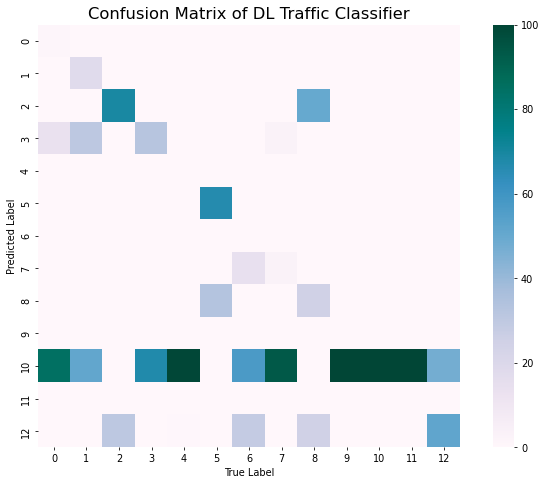

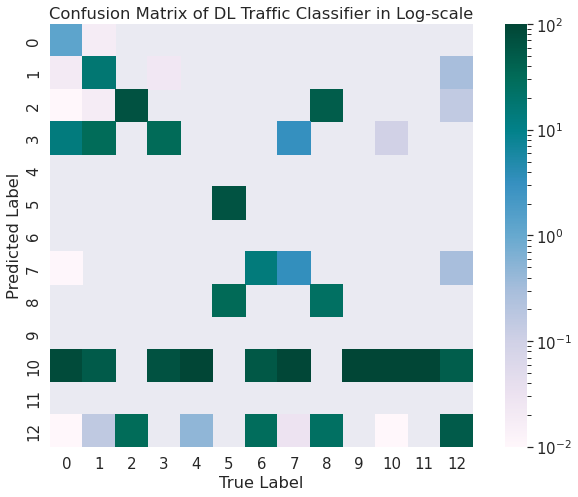

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

classes = [str(k) for k in range(13)]
mat = confusion_matrix(categorical_labels_test, prediction_test, normalize = 'true')

plt.figure(figsize=(12, 8), dpi=70)
cmap = cm.get_cmap('PuBuGn')
ax = plt.subplot()
sns.heatmap(mat.T*100, square=True, annot=False, vmin=0.0, vmax=100.0, cmap=cmap, cbar=True,ax=ax,xticklabels=classes, yticklabels=classes) # plot via seaborn
sns.set(font_scale=1.4) # for label size
plt.xlabel('True Label')
plt.ylabel('Predicted Label');
plt.title('Confusion Matrix of DL Traffic Classifier')

plt.figure(figsize=(12, 8), dpi=70)
ax = plt.subplot()
sns.heatmap(mat.T*100, square=True, annot=False, vmin=0.0, vmax=100.0, cmap=cmap, cbar=True, norm=LogNorm(vmin=0.01, vmax=100.0),ax=ax,xticklabels=classes, yticklabels=classes) # plot via seaborn in logscale
sns.set(font_scale=1.4) # for label size
plt.xlabel('True Label')
plt.ylabel('Predicted Label');
plt.title('Confusion Matrix of DL Traffic Classifier in Log-scale')